In [130]:
import json
import collections
import numpy as np
import scipy.stats

num_prompts = 27
seeds = [0, 42, 23]
rte_model_address = "./experiments/{}/{}/"
setup_name = "{}shots-p{}-i0-seed{}/"
t5_base_rte = [[], [], []]
t5_11b_rte = [[], [], []]

def read_accuracy(address, model, seedID, promptID):
    if model == "T5-base":
        return t5_base_rte[seedID][promptID]
    elif model == "T5-11B":
        return t5_11b_rte[seedID][promptID]
    else:
        with open(address + "results.json") as f:
            tmp = json.load(f)
        return tmp['test_set_after_training']['acc']
temp = ["roberta-base", "deberta-v3-base", "albert-base-v2", "bert-base-uncased", "bert-base-cased", "xlnet-base-cased", "roberta-large", "deberta-v3-large", "albert-large-v2", "xlnet-large-cased", "deberta-v2-xlarge"]

temp = ["roberta-base", "roberta-large", "bert-base-uncased", "bert-base-cased", "deberta-v3-base", "deberta-v3-large", "albert-large-v2", "albert-base-v2", "deberta-v2-xlarge", "xlnet-base-cased", "xlnet-large-cased"]

models = ["bert-base-cased", "bert-base-uncased", "albert-base-v2", "albert-large-v2", "roberta-base", "roberta-large", "deberta-v3-base", "deberta-v3-large", "xlnet-base-cased", "xlnet-large-cased"]

# models = ["albert-base-v2", "albert-large-v2", "deberta-v3-base", "bert-base-uncased", "bert-base-cased","xlnet-base-cased", "roberta-base", "deberta-v3-large", "mdeberta-v3-base", "xlnet-large-cased", "roberta-large", "deberta-v2-xlarge"]
# rte: roberta, deberta, albert, xlnet, bert
# models = ["albert-base-v2", "albert-large-v2", "deberta-v3-base", "bert-base-uncased", "bert-base-cased","xlnet-base-cased", "roberta-base", "deberta-v3-large", "xlnet-large-cased", "roberta-large"]

#, "T5-base", "T5-11B"
def get_model_combs(models):
    model_combs = []
    for i in range(len(models)):
        for j in range(len(models)):
            model_combs.append((models[i], models[j]))
    return model_combs

def h_distance(p, q):
  # distance between p and d
  # p and q are np array probability distributions
  n = len(p)
  sum = 0.0
  for i in range(n):
    sum += (np.sqrt(p[i]) - np.sqrt(q[i]))**2
  result = (1.0 / np.sqrt(2.0)) * np.sqrt(sum)
  return result

In [131]:
task = "rte"
n_shot = 100
num_prompts = 11

In [132]:
# go through all needed files
from os.path import exists
not_exists = []
ne_models = []
for model in models:
    for i in range(num_prompts):
        for seedID, seed in enumerate(seeds):
            if not exists(rte_model_address.format(task, model) + setup_name.format(n_shot, i, seed) + "results.json"):
                not_exists.append(f"{rte_model_address.format(task, model)}{setup_name.format(n_shot, i, seed)}results.json")
                ne_models.append(model)
ne_models = set(ne_models)
for model in ne_models:
    models.remove(model)

model_combs = get_model_combs(models)

In [133]:
# Accuracy
correlation = {}
modelAccDict = {}
for model_pair in model_combs:
    model1_dev_acc, model2_dev_acc = [], []
    model1 = model_pair[0]
    model2 = model_pair[1]
    for i in range(num_prompts):
        avg_dev1_acc, avg_dev2_acc = 0, 0
        for seedID, seed in enumerate(seeds):
            dev1_acc = read_accuracy(rte_model_address.format(task, model1) + setup_name.format(n_shot, i, seed), model1, seedID, i)
            dev2_acc = read_accuracy(rte_model_address.format(task, model2) + setup_name.format(n_shot, i, seed), model2, seedID, i)
            avg_dev1_acc += dev1_acc
            avg_dev2_acc += dev2_acc
        avg_dev1_acc /= len(seeds)
        avg_dev2_acc /= len(seeds)
        model1_dev_acc.append(avg_dev1_acc)
        model2_dev_acc.append(avg_dev2_acc)
    modelAccDict[model1] = model1_dev_acc
    modelAccDict[model2] = model2_dev_acc
    # pearsonr
    pearsonr = scipy.stats.pearsonr(model2_dev_acc, model1_dev_acc)
    # spearmanr
    spearmanr = scipy.stats.spearmanr(model2_dev_acc, model1_dev_acc)
    # kendalltau
    kendalltau = scipy.stats.kendalltau(model2_dev_acc, model1_dev_acc)
    # hellinger distance
    hellinger = h_distance(model2_dev_acc, model1_dev_acc)
    correlation[(model1, model2)] = [pearsonr[0], spearmanr.correlation, kendalltau.correlation, hellinger]
    print(f"{model1}, {model2} :\n pearsonr:{pearsonr} \n spearmanr: {spearmanr} \n kendalltau: {kendalltau} \n hellinger: {hellinger}")
    # return modelAccDict, pearsonr, spearmanr, kendalltau, hellinger, correlation

bert-base-cased, bert-base-cased :
 pearsonr:(1.0, 0.0) 
 spearmanr: SpearmanrResult(correlation=1.0, pvalue=0.0) 
 kendalltau: KendalltauResult(correlation=0.9999999999999999, pvalue=2.3434607292951112e-05) 
 hellinger: 0.0
bert-base-cased, bert-base-uncased :
 pearsonr:(0.38982872253951073, 0.23595027757748113) 
 spearmanr: SpearmanrResult(correlation=0.3127853881278539, pvalue=0.34900262469508525) 
 kendalltau: KendalltauResult(correlation=0.2777777777777778, pvalue=0.24006467448149116) 
 hellinger: 0.039917350396265
bert-base-cased, albert-base-v2 :
 pearsonr:(-0.11860837239177648, 0.728339547033304) 
 spearmanr: SpearmanrResult(correlation=-0.0684931506849315, pvalue=0.8414033243583003) 
 kendalltau: KendalltauResult(correlation=-0.018518518518518517, pvalue=0.9375721747299168) 
 hellinger: 0.08733322923416666
bert-base-cased, albert-large-v2 :
 pearsonr:(0.7083634248474233, 0.014699368201824502) 
 spearmanr: SpearmanrResult(correlation=0.7922374429223744, pvalue=0.003647682379373

In [134]:
# get data



# modelAccDict, pearsonr, spearmanr, kendalltau, hellinger, correlation = all_accuracy(task, model_combs, , )

In [135]:
modelAccDict

{'bert-base-cased': [0.5186522262334536,
  0.5114320096269555,
  0.5126353790613718,
  0.49338146811071,
  0.5451263537906138,
  0.5054151624548736,
  0.5210589651022864,
  0.53309265944645,
  0.5114320096269555,
  0.5030084235860409,
  0.5523465703971119],
 'bert-base-uncased': [0.46450060168471713,
  0.496991576413959,
  0.5162454873646211,
  0.5054151624548736,
  0.51985559566787,
  0.4837545126353791,
  0.5018050541516246,
  0.5030084235860409,
  0.5054151624548736,
  0.5150421179302046,
  0.5282791817087845],
 'albert-base-v2': [0.5499398315282792,
  0.5703971119133574,
  0.5896510228640192,
  0.5607701564380264,
  0.5463297232250302,
  0.5643802647412756,
  0.5992779783393501,
  0.5824308062575211,
  0.5547533092659447,
  0.5679903730445246,
  0.5607701564380264],
 'albert-large-v2': [0.5884476534296029,
  0.5884476534296029,
  0.5728038507821901,
  0.5607701564380264,
  0.6726835138387485,
  0.5667870036101083,
  0.6173285198555957,
  0.5752105896510229,
  0.5463297232250302,
  

In [136]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [137]:
pearsonr = {}
spearmanr = {}
kendalltau = {}
hellinger = {}
for i, df in enumerate([pearsonr, spearmanr, kendalltau, hellinger]):
    for model1 in models:
        df[model1] = []
        for model2 in models:
            df[model1].append(correlation[(model1, model2)][i])

pearsonr_list = []
spearmanr_list = []
kendalltau_list = []
hellinger_list = []
for i, l in enumerate([pearsonr_list, spearmanr_list, kendalltau_list, hellinger_list]):
    for model1 in models:
        for j, model2 in enumerate(models):
            if model1 != model2:
                l.append((model1, model2, correlation[(model1, model2)][i]))
pearsonr_list = sorted(pearsonr_list, key=lambda t: t[2], reverse=True)
spearmanr_list = sorted(spearmanr_list, key=lambda t: t[2], reverse=True)
kendalltau_list = sorted(kendalltau_list, key=lambda t: t[2], reverse=True)
hellinger_list = sorted(hellinger_list, key=lambda t: t[2], reverse=True)

In [138]:
# We then want to store these sorted results in csv file
import csv

with open('sorted_correlation.csv', "w", newline='') as f:
    csv_out=csv.writer(f)
    csv_out.writerow(["task", "num_shots", "num_prompts", 'model1', 'model2', "pearsonr", "spearmanr", "kendalltau", "hellinger"])
    for (ms, values) in correlation.items():
        if ms[0] != ms[1]:
            csv_out.writerow([task, n_shot, num_prompts] + list(ms) + list(values))

In [139]:
pearsonr_df = pd.DataFrame(pearsonr)
spearmanr_df = pd.DataFrame(spearmanr)
kendalltau_df = pd.DataFrame(kendalltau)
hellinger_df = pd.DataFrame(hellinger)

In [140]:
pearsonr_df.mean().mean()

0.34861922295100495

In [141]:
spearmanr_df.mean()

bert-base-cased      0.304032
bert-base-uncased    0.337521
albert-base-v2       0.149813
albert-large-v2      0.195284
roberta-base         0.445208
roberta-large        0.142750
deberta-v3-base      0.317925
deberta-v3-large     0.462289
xlnet-base-cased     0.202943
xlnet-large-cased    0.282382
dtype: float64

In [142]:
kendalltau_df.mean()

bert-base-cased      0.255386
bert-base-uncased    0.269322
albert-base-v2       0.154913
albert-large-v2      0.159564
roberta-base         0.339455
roberta-large        0.129124
deberta-v3-base      0.238651
deberta-v3-large     0.370499
xlnet-base-cased     0.180603
xlnet-large-cased    0.231211
dtype: float64

In [143]:
hellinger_df.mean()

bert-base-cased      0.132127
bert-base-uncased    0.151055
albert-base-v2       0.094851
albert-large-v2      0.095981
roberta-base         0.087718
roberta-large        0.163260
deberta-v3-base      0.106331
deberta-v3-large     0.117977
xlnet-base-cased     0.091824
xlnet-large-cased    0.124734
dtype: float64

In [144]:
pearsonr_df

,bert-base-cased,bert-base-uncased,albert-base-v2,albert-large-v2,roberta-base,roberta-large,deberta-v3-base,deberta-v3-large,xlnet-base-cased,xlnet-large-cased
0,1.000000,0.389829,-0.118608,0.708363,0.760654,-0.250538,0.396836,0.479087,0.551806,-0.208714
1,0.389829,1.000000,0.137259,0.229892,0.364266,0.402442,0.630775,0.677099,0.498309,0.219607
2,-0.118608,0.137259,1.000000,-0.124160,-0.007020,0.493359,0.059657,0.250357,-0.452336,0.705604
3,0.708363,0.229892,-0.124160,1.000000,0.559910,0.006352,0.036620,0.111431,0.365899,-0.334692
4,0.760654,0.364266,-0.007020,0.559910,1.000000,0.123531,0.565519,0.717095,0.431934,0.239379
5,-0.250538,0.402442,0.493359,0.006352,0.123531,1.000000,0.041176,0.311430,-0.159599,0.606966
6,0.396836,0.630775,0.059657,0.036620,0.565519,0.041176,1.000000,0.690036,0.375415,0.326797
7,0.479087,0.677099,0.250357,0.111431,0.717095,0.311430,0.690036,1.000000,0.418799,0.564481
8,0.551806,0.498309,-0.452336,0.365899,0.431934,-0.159599,0.375415,0.418799,1.000000,-0.361341
9,-0.208714,0.219607,0.705604,-0.334692,0.239379,0.606966,0.326797,0.564481,-0.361341,1.000000


In [145]:
# paras = [" (11M)", " (17M)", " (98M)", " (110M)", " (110M)", " (110M)", " (125M)", " (131M)", " (340M)", " (355M)"]
# models = [m + p for m, p in zip(models, paras)]

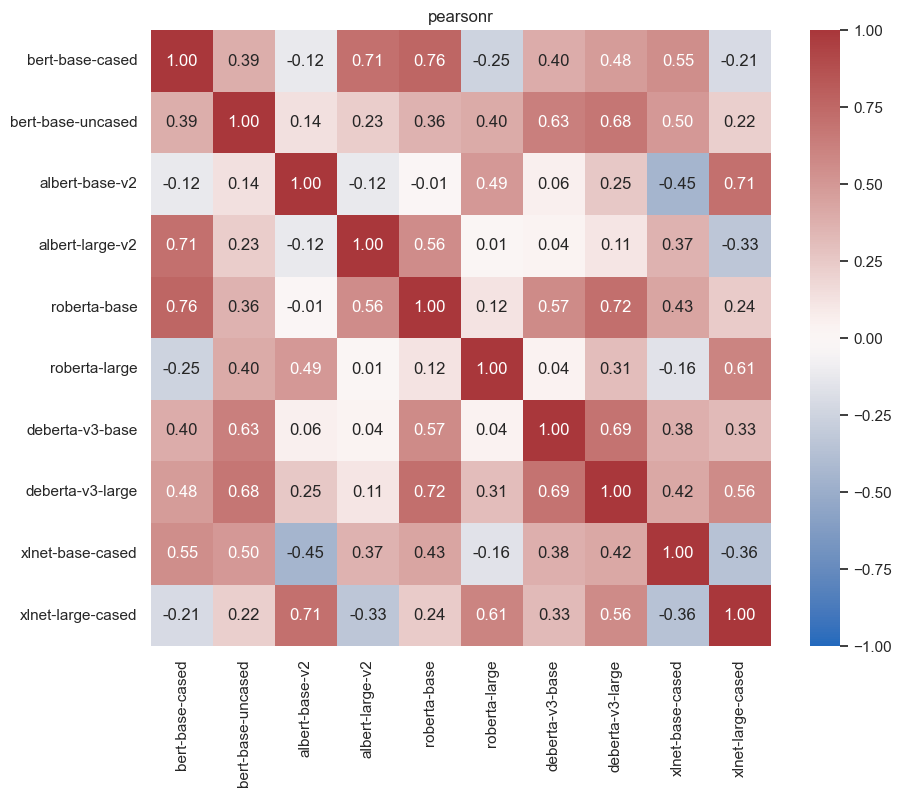

In [146]:
pearsonr_df.index=models
sns.set(rc={'figure.figsize':(10,8)})
ax = plt.axes()
pearsonr_plot = sns.heatmap(pearsonr_df, annot=True, fmt=".2f", ax=ax, cmap="vlag", vmax=1, vmin=-1)
ax.set_title('pearsonr')
fig = pearsonr_plot.get_figure()
fig.savefig(f"task={task}_n={n_shot}_pearsonr.png", dpi=fig.dpi, bbox_inches='tight')

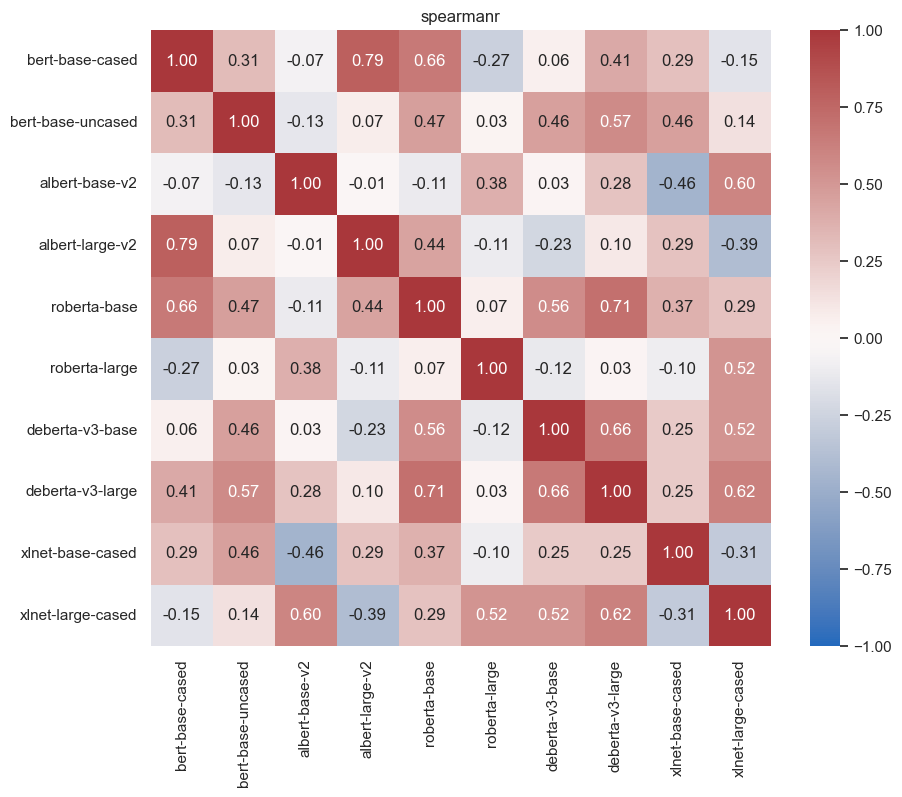

In [147]:
spearmanr_df.index=models
ax = plt.axes()
spearmanr_plot = sns.heatmap(spearmanr_df, annot=True, fmt=".2f", ax=ax, cmap="vlag", vmax=1, vmin=-1)
ax.set_title('spearmanr')
fig = spearmanr_plot.get_figure()
fig.savefig(f"task={task}_n={n_shot}_spearmanr.png", dpi=fig.dpi, bbox_inches='tight')

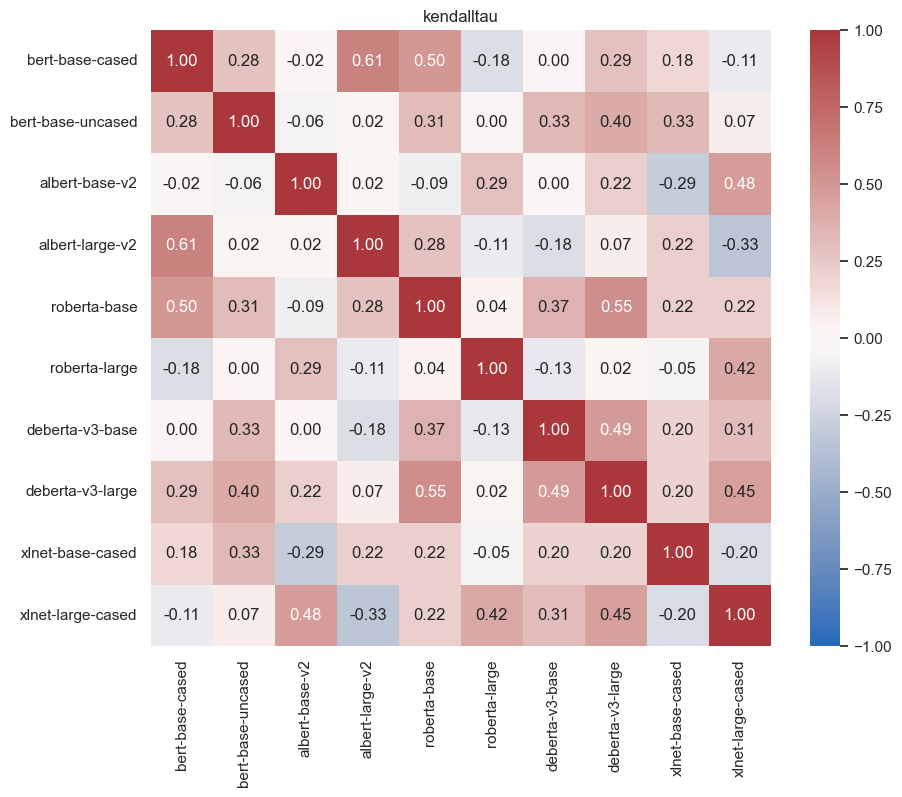

In [148]:
kendalltau_df.index=models
ax = plt.axes()
kendalltau_plot = sns.heatmap(kendalltau_df, annot=True, fmt=".2f", ax=ax, cmap="vlag", vmax=1, vmin=-1)
ax.set_title('kendalltau')
fig = kendalltau_plot.get_figure()
fig.savefig(f"task={task}_n={n_shot}_kendalltau.png", dpi=fig.dpi, bbox_inches='tight')

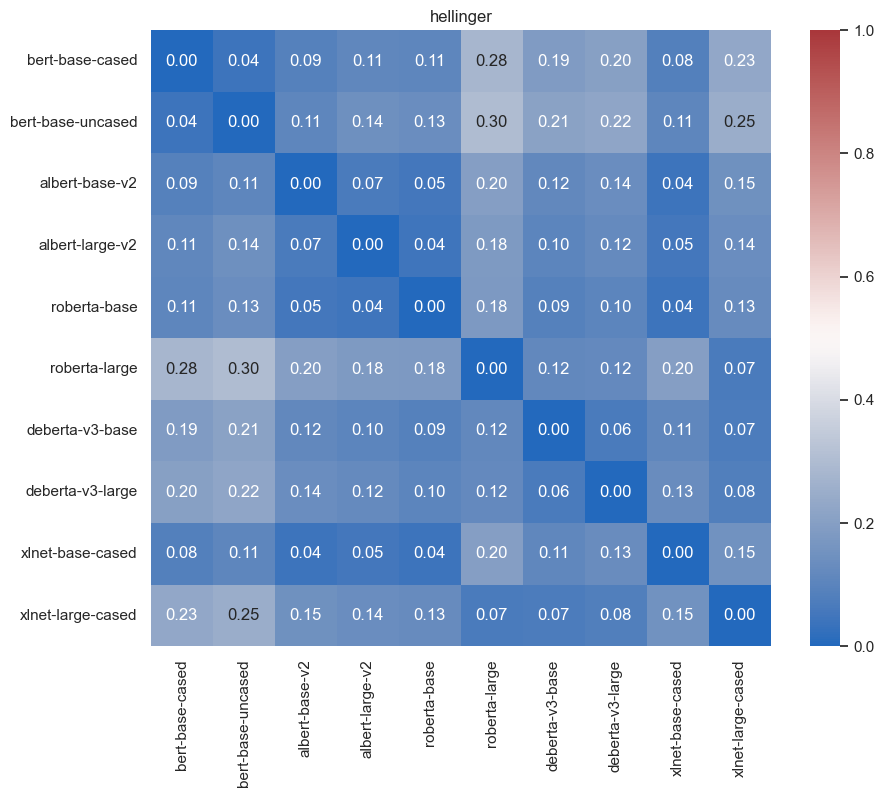

In [149]:
hellinger_df.index=models
ax = plt.axes()
palette = sns.color_palette("vlag", n_colors=100000)
hellinger_plot = sns.heatmap(hellinger_df, annot=True, fmt=".2f", ax=ax, cmap=palette, vmax=1, vmin=0)
ax.set_title('hellinger')
fig = hellinger_plot.get_figure()
fig.savefig(f"task={task}_n={n_shot}_hellinger.png", dpi=fig.dpi, bbox_inches='tight')

In [150]:
modelAccDict_df = pd.DataFrame(modelAccDict)
modelAccDict_df

,bert-base-cased,bert-base-uncased,albert-base-v2,albert-large-v2,roberta-base,roberta-large,deberta-v3-base,deberta-v3-large,xlnet-base-cased,xlnet-large-cased
0,0.518652,0.464501,0.549940,0.588448,0.563177,0.613718,0.581227,0.536703,0.565584,0.628159
1,0.511432,0.496992,0.570397,0.588448,0.566787,0.725632,0.569194,0.599278,0.578821,0.638989
2,0.512635,0.516245,0.589651,0.572804,0.569194,0.712395,0.645006,0.612515,0.560770,0.683514
3,0.493381,0.505415,0.560770,0.560770,0.528279,0.706378,0.619735,0.555957,0.557160,0.640193
4,0.545126,0.519856,0.546330,0.672684,0.620939,0.702768,0.638989,0.651023,0.582431,0.632972
5,0.505415,0.483755,0.564380,0.566787,0.592058,0.681107,0.660650,0.608905,0.559567,0.661853
6,0.521059,0.501805,0.599278,0.617329,0.605295,0.760529,0.641396,0.682310,0.558363,0.709988
7,0.533093,0.503008,0.582431,0.575211,0.592058,0.679904,0.629362,0.682310,0.552347,0.677497
8,0.511432,0.505415,0.554753,0.546330,0.598075,0.737665,0.647413,0.675090,0.570397,0.690734
9,0.503008,0.515042,0.567990,0.555957,0.577617,0.699158,0.649819,0.712395,0.577617,0.689531


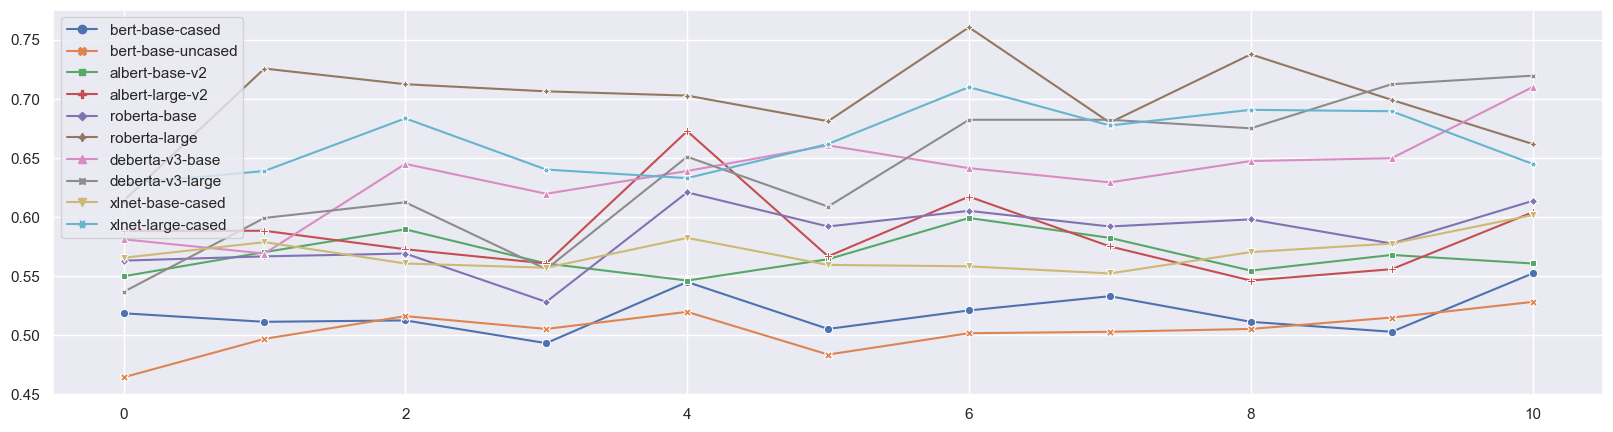

In [151]:
sns.set(rc={'figure.figsize':(20,5)})
all_acc_plot = sns.lineplot(data=modelAccDict_df, markers=True, dashes=False)
fig = all_acc_plot.get_figure()
fig.savefig(f"task={task}_n={n_shot}_all_acc.png", dpi=fig.dpi)

In [152]:
10, 15, 20, 32, 50, 70, 100, 150, 200, 320, 500, 750, 1000, 1500, 2500

(10, 15, 20, 32, 50, 70, 100, 150, 200, 320, 500, 750, 1000, 1500, 2500)

In [153]:
# correlation of performance performance across different number of training points between three different seeds on the same model.
# we can observe the correlation of the performance of the same model between different seeds
# observe if seed will change the model's performance pattern
#
# correlation of average performances across different models (average based on seed, 3个seed 现在increase to 5，同时我们也要去add training points)
# observe performance across different models